In [ ]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.ray import Ray
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, Deflector, Plane
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.utils import fibonacci_spiral, FresnelPropagator
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

from temgym_core.run import run_to_end, run_iter
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [ ]:
x_rays = jnp.linspace(0.0, 1e-3, 25)
rays = Ray(x=x_rays, 
           y=jnp.zeros_like(x_rays), 
           dx=jnp.zeros_like(x_rays), 
           dy=jnp.zeros_like(x_rays), 
           z=jnp.ones_like(x_rays) * -0.1 ,
            pathlength=jnp.zeros_like(x_rays))

rays.to_vector()

input_plane = Plane(z=-0.1)
lens = Lens(focal_length=0.2, z=0.0)
output_plane = Plane(z=0.2)

out_rays = list(run_iter(rays, [input_plane, lens, output_plane]))


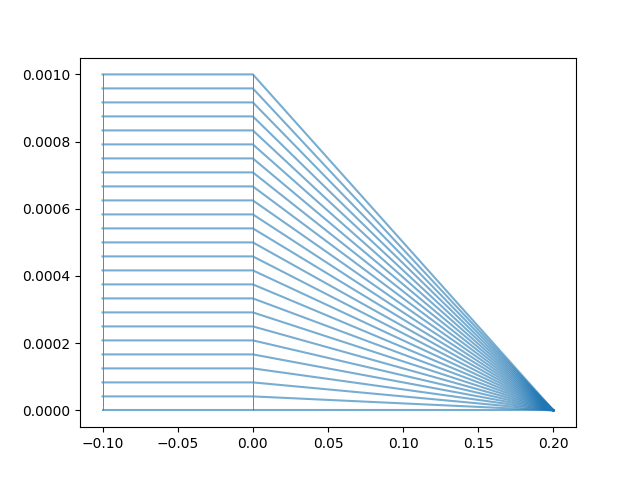

In [ ]:
# Plot ray trajectories and overlay optical path length (OPL) at input plane and just after the lens
plt.figure()

ray_states = [r for _, r in out_rays]
n_rays = len(ray_states[0].x)

# Plot individual ray trajectories across stages
for j in range(n_rays):
    z_path = np.array([np.asarray(r.z[j]) for r in ray_states])
    x_path = np.array([np.asarray(r.x[j]) for r in ray_states])
    plt.plot(z_path, x_path, color='C0', alpha=0.6)

# Connect all pairs of rays within each stage
for r in ray_states:
    z_k = np.asarray(r.z)
    x_k = np.asarray(r.x)
    for p in range(n_rays):
        for q in range(p + 1, n_rays):
            plt.plot([z_k[p], z_k[q]], [x_k[p], x_k[q]],
                     color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Find indices for input plane and lens states
input_idx = next(i for i, (comp, _) in enumerate(out_rays)
                 if isinstance(comp, Plane) and comp.z == input_plane.z)
lens_idx = next(i for i, (comp, _) in enumerate(out_rays)
                if isinstance(comp, Lens) and comp.z == lens.z and comp.focal_length == lens.focal_length)

rin = ray_states[input_idx]
rl = ray_states[lens_idx]
re = ray_states[-1]

# Extract positions and OPLs
z_in, x_in, L_in = np.asarray(rin.z), np.asarray(rin.x), np.asarray(rin.pathlength)
z_l, x_l, L_l = np.asarray(rl.z), np.asarray(rl.x), np.asarray(rl.pathlength)
z_e, x_e, L_e = np.asarray(re.z), np.asarray(re.x), np.asarray(re.pathlength)

# Interpolate OPL along each ray and find equal-OPL points across rays

# Nodes per ray (z, x, OPL)
z_nodes = np.vstack([z_in, z_l, z_e])      # shape (3, n_rays)
x_nodes = np.vstack([x_in, x_l, x_e])      # shape (3, n_rays)
L_nodes = np.vstack([L_in, L_l, L_e])      # shape (3, n_rays)

reference_opl = L_nodes[-1, -1]
opl_after_lens = L_e - reference_opl
# for j in range(n_rays):



In [ ]:
central_ray_z = z_nodes[:, 0]
central_ray_opl = L_nodes[:, 0]

outer_ray_z = z_nodes[:, -1]
outer_ray_opl = L_nodes[:, -1]

print("Central ray OPL:", central_ray_opl)
print("Outer ray OPL:", outer_ray_opl)

reference_opl = central_ray_opl[1] # OPL at lens for central ray


ref_parabola_x = []
ref_parabola_z = []
t = np.zeros(n_rays)
for j in range(n_rays):
    ray_x = x_nodes[:, j]
    ray_z = z_nodes[:, j]
    ray_opl = L_nodes[:, j]

    d = np.sqrt((ray_x[-1]-ray_x[1])**2 + (ray_z[-1]-ray_z[1])**2)

    # Find direction vectors
    u_x = (ray_x[-1]-ray_x[1])/d
    u_z = (ray_z[-1]-ray_z[1])/d

    # Find what distance along the aberrated line from the pupil plane we need to move before the aberrated wave is the same phase as the reference wave.
    t = ray_opl[-1] - ray_opl[1] - 0.2

    ref_parabola_x_ = ray_x[1] + t*u_x
    ref_parabola_z_ = ray_z[1] + t*u_z

    plt.plot(ref_parabola_z_, ref_parabola_x_, 'go', alpha=0.5)

    ref_parabola_x.append(ref_parabola_x_)
    ref_parabola_z.append(ref_parabola_z_)



Central ray OPL: [0.  0.1 0.3]
Outer ray OPL: [0.        0.0999975 0.3      ]


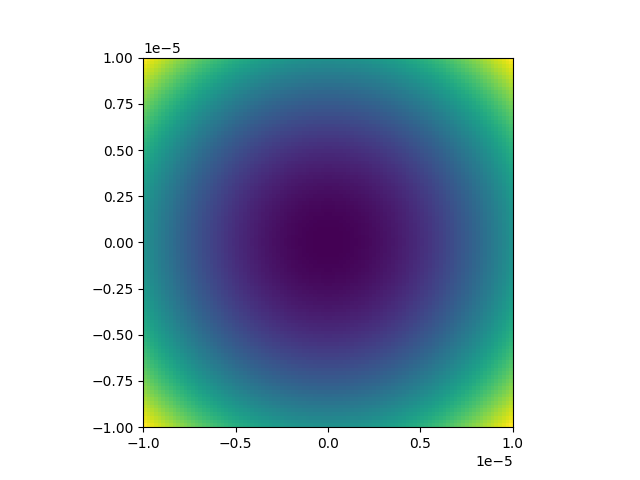

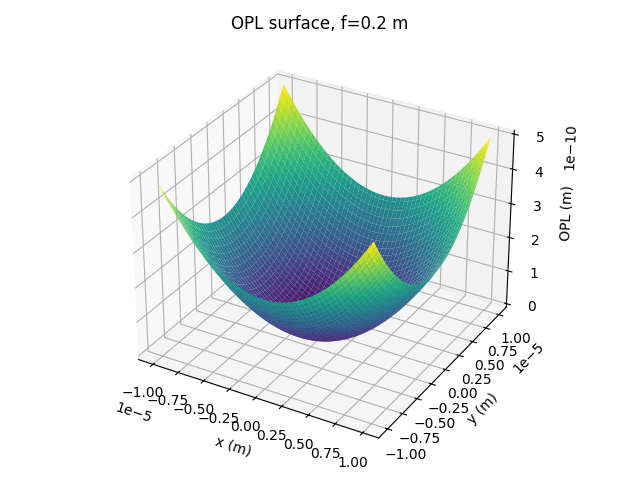

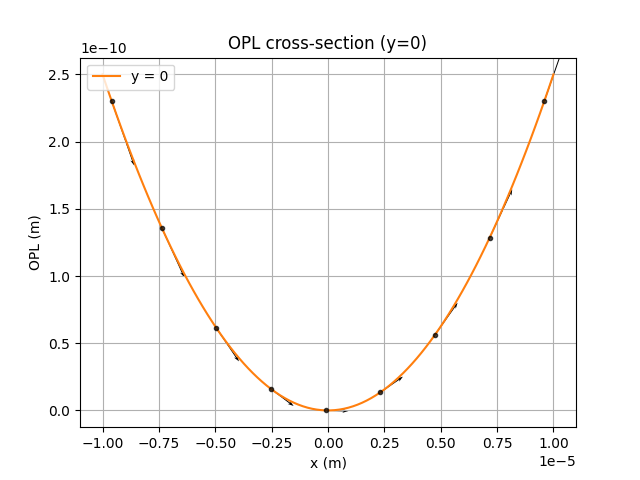

In [ ]:
x = np.linspace(-1e-5, 1e-5, 100)
y = np.linspace(-1e-5, 1e-5, 100)
X, Y = np.meshgrid(x, y)
opl = (X**2 + Y**2) / (2 * lens.focal_length)


plt.figure()
plt.imshow(opl, extent=(x[0], x[-1], y[0], y[-1]))

# 3D surface plot of OPL
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, opl, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('OPL (m)')
ax.set_title(f'OPL surface, f={lens.focal_length:.3g} m')
plt.tight_layout()


In [ ]:

# 2D cross section at y = 0
iy0 = np.argmin(np.abs(y))          # index closest to y=0
x_line = X[iy0, :]
opl_line = opl[iy0, :]
plt.figure()
plt.plot(x_line, opl_line, 'C1-', label='y = 0')
plt.xlabel('x (m)')
plt.ylabel('OPL (m)')
plt.title('OPL cross-section (y=0)')
plt.legend()
plt.grid(True)


# Plot local tangent vectors along the parabola OPL = x^2 / (2f) at selected points
ax = plt.gca()

# choose evenly spaced indices along the curve (skip endpoints for clarity)
idx = np.linspace(2, x_line.size - 3, 9, dtype=int)

# slope d(OPL)/dx = x / f
m = x_line[idx] / lens.focal_length

# choose a small horizontal length for the tangent arrows
arrow_len_x = (x_line[-1] - x_line[0]) * 0.05  # 5% of full span

# tangent vector components
tx = np.full_like(m, arrow_len_x)
ty = m * arrow_len_x

# draw arrows
ax.quiver(x_line[idx], opl_line[idx], tx, ty,
          angles='xy', scale_units='xy', scale=1,
          color='k', width=0.002, headwidth=4, headlength=6)

# optional marker at base points
ax.plot(x_line[idx], opl_line[idx], 'ko', ms=3, alpha=0.7)

ax.legend(loc='upper left')
